In [432]:
import tensorflow as tf
import numpy as np
import pandas
import os
import matplotlib.pyplot as plt

%matplotlib inline

def featureNormalise(X):
    mu = np.mean(X,0)
    sigma = np.std(X,0, ddof=1)
    return ((X - mu) / sigma), mu, sigma

def mapFeatures(x1, x2):
    degree = 6;
    out = np.ones([x1.shape[0],1]);
    for i in range(1, degree+1):
        for j in range(0, i+1):
            out = np.hstack((out,np.array((x1**(i-j)) * (x2**j)).reshape(x1.shape[0],1)))
    return out


## Load Training data
dataset = pandas.read_csv("data/ex4data1_X.csv", header=None)
labels = pandas.read_csv("data/ex4data1_y.csv", header=None)

m,n = dataset.shape
X = dataset.values.reshape(m,n).astype(np.float32)
y_raw = labels.values.ravel() - 1


## Load Validation and Test data

## Normalise
x_norm = X#, mu, sigma = featureNormalise(X)

# Add bias
x_with_bias = np.hstack((np.ones((x_norm.shape[0],1)),x_norm)).astype(np.float32)
#x_with_bias = mapFeatures(x_norm[:,0], x_norm[:,1]).astype(np.float32)
#m,n = x_with_bias.shape

In [456]:
import pandas as pd
##
## Split (Train/Val/Test)
##
def split(data, train=.6, val=.2, test=.2):
    idx = np.arange(0,len(data)) / float(len(data))
    msk1 = data[idx<train]
    msk2 = data[(idx>=train) & (idx<(train + val))]
    msk3 = data[(idx>=(train+val))]
    return [msk1.values, msk2.values, msk3.values]

##
## Shuffle data
##
def shuffle(data):
    return data.sample(frac=1).reset_index(drop=True)

def encode(data):
    y = np.zeros([data.shape[0], 10]).astype(np.float32)
    for i in range(0,data.shape[0]):
        y[i,data[i]] = 1.
    return y

shuffled = shuffle(pd.DataFrame(np.hstack((x_with_bias,y_raw.reshape(m,1)))))
train_X, val_X, test_X = split(shuffled)
train_y = encode(train_X[:,-1].reshape(-1,1).astype(np.integer))
val_y = encode(val_X[:,-1].reshape(-1,1).astype(np.integer))
test_y = encode(test_X[:,-1].reshape(-1,1).astype(np.integer))

m = train_X.shape[0]
n = train_X.shape[1] - 2

In [457]:

# We'll bundle groups of examples during training for efficiency.
# This defines the size of the batch.
BATCH_SIZE = m
HIDDEN_UNITS = 25
NUM_FEATURES = n 
NUM_LABELS = 10
# The random seed that defines initialization.
SEED = 42

# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step, which we'll write once we define the graph structure.
train_data_node = tf.placeholder(tf.float32, shape=(None, NUM_FEATURES+1))
train_labels_node = tf.placeholder(tf.float32, shape=(None, NUM_LABELS))

length = tf.Variable(tf.constant(m, dtype=tf.float32))

# The variables below hold all the trainable weights. For each, the
# parameter defines how the variables will be initialized. 
# TODO : These should be pulled from a config file

Theta1 = tf.Variable( tf.truncated_normal([HIDDEN_UNITS, (NUM_FEATURES+1)], stddev=0.1, seed=SEED))

Theta2 = tf.Variable( tf.truncated_normal([NUM_LABELS, HIDDEN_UNITS],stddev=0.1, seed=SEED))
bias2 = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))
    
print('Done')

Done


In [458]:
def model(X, Theta1, Theta2, bias):
    """The Model definition."""
    # Perceptron
    
    layer1 = tf.nn.sigmoid(tf.matmul(X, tf.transpose(Theta1)))
                        
    output = tf.nn.bias_add(tf.matmul(layer1, tf.transpose(Theta2)),bias)

    return output
    
print('Done')

Done


In [459]:
yhat = model(train_data_node, Theta1, Theta2, bias2)

lam = .06

# Change the weights by subtracting derivative with respect to that weight
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=train_labels_node, logits=yhat))
# Regularization using L2 Loss function 
regularizer = tf.nn.l2_loss(Theta1) + tf.nn.l2_loss(Theta2)
loss_reg = loss + (lam / tf.to_float(tf.shape(train_data_node)[0])) * regularizer

# Optimizer: 

# Gradient Descent
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss_reg, options={'maxiter':500})
#update_weights = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

# Predictions
train_prediction = yhat

print('Done')

Done


In [460]:
# Keep track of the loss at each iteration so we can chart it later
J = []

def loss_callback(loss):
    J.append(loss)
        
def train(feed_dict, train=True):

    #optimizer.minimize(feed_dict=feed_dict, fetches=[loss_reg], loss_callback=loss_callback)
    if (train):
        optimizer.minimize(feed_dict=feed_dict, fetches=[loss_reg], loss_callback=loss_callback )

    return loss.eval(feed_dict)

In [461]:
## Train 
J = []

# Create a new interactive session that we'll use in
# subsequent code cells.
s = tf.InteractiveSession()

# Initialize all the variables we defined above.
tf.global_variables_initializer().run()

final_loss = train({train_data_node: train_X[:,:NUM_FEATURES+1], train_labels_node: train_y[:,:]})


INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  Objective function value: 0.026939
  Number of iterations: 372
  Number of functions evaluations: 388


In [462]:
predictions = train_prediction.eval({train_data_node: train_X[:,:NUM_FEATURES+1], train_labels_node: train_y[:,:]})
a = np.argmax(predictions,axis=1) 
np.sum(a == train_X[:,-1]) / np.float32(train_X.shape[0])

0.9996666666666667

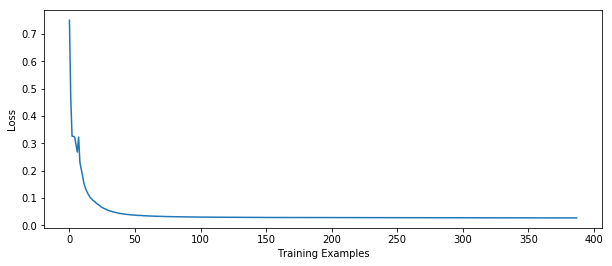

In [463]:
# Show the fit and the loss over time.
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

x = np.array(range(0, len(J)))
ax1.plot(x, np.array(J).ravel())
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training Examples")
plt.show()

In [455]:
final_loss

0.0078394506